# Audio Classification with RNN and MFCC

This notebook demonstrates how to classify audio files using Mel-Frequency Cepstral Coefficients (MFCC) features and a Recurrent Neural Network (RNN/LSTM).

In [27]:
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [28]:
# Configuration
TRAIN_DIR = 'dataset/train'
TEST_DIR = 'dataset/test'
CLASSES = ['AS', 'MR', 'MS', 'MVP', 'N']
N_MFCC = 13
# Max Pad Len determines the time steps for the LSTM.
# Ensure this covers the duration of your audio files.
# Example: 1 second of audio at 22050Hz with default hop_length=512 produces ~44 frames.
MAX_PAD_LEN = 100 

In [29]:
def extract_mfcc(file_path, n_mfcc=13, max_pad_len=100):
    try:
        # Load audio file
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
        
        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
        
        # Padding or Truncating to ensure fixed shape (n_mfcc, max_pad_len)
        if mfcc.shape[1] > max_pad_len:
            mfcc = mfcc[:, :max_pad_len]
        else:
            pad_width = max_pad_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
            
        # Transpose to shape (Time, Features) for LSTM input
        return mfcc.T 
    except Exception as e:
        print(f"Error parsing {file_path}: {e}")
        return None

In [30]:
def load_data(data_dir, classes):
    features = []
    labels = []
    
    for label in classes:
        class_dir = os.path.join(data_dir, label)
        if not os.path.exists(class_dir):
            print(f"Warning: Directory not found {class_dir}")
            continue
            
        print(f"Loading class: {label}...")
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            # Basic check for likely audio files
            if os.path.isfile(file_path):
                data = extract_mfcc(file_path, N_MFCC, MAX_PAD_LEN)
                if data is not None:
                    features.append(data)
                    labels.append(label)
                    
    return np.array(features), np.array(labels)

print("Loading Train Data...")
X_train, y_train = load_data(TRAIN_DIR, CLASSES)

print("Loading Test Data...")
X_test, y_test = load_data(TEST_DIR, CLASSES)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

Loading Train Data...
Loading class: AS...
Loading class: MR...
Loading class: MS...
Loading class: MVP...
Loading class: N...
Loading Test Data...
Loading class: AS...
Loading class: MR...
Loading class: MS...
Loading class: MVP...
Loading class: N...
X_train shape: (900, 100, 13)
X_test shape: (100, 100, 13)


In [31]:
# Label Encoding
le = LabelEncoder()
y_train_encoded = to_categorical(le.fit_transform(y_train))
y_test_encoded = to_categorical(le.transform(y_test))

print("Mapping:")
for i, item in enumerate(le.classes_):
    print(f"{item} -> {i}")

Mapping:
AS -> 0
MR -> 1
MS -> 2
MVP -> 3
N -> 4


In [32]:
# Build LSTM Model
input_shape = (MAX_PAD_LEN, N_MFCC)

model = Sequential()
model.add(LSTM(128, input_shape=input_shape, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(CLASSES), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

c:\Users\Rafli\anaconda3\envs\LLM\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 128)            │        72,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,285 (317.52 KB)

 Trainable params: 81,285 (317.52 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Train Model
if len(X_train) > 0:
    history = model.fit(
        X_train, y_train_encoded, 
        epochs=50, 
        batch_size=32, 
        validation_data=(X_test, y_test_encoded)
    )
else:
    print("No training data available.")

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.3856 - loss: 1.4518 - val_accuracy: 0.7400 - val_loss: 1.0187
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6167 - loss: 1.0235 - val_accuracy: 0.8400 - val_loss: 0.6391
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7011 - loss: 0.8259 - val_accuracy: 0.8700 - val_loss: 0.6009
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7111 - loss: 0.7700 - val_accuracy: 0.8900 - val_loss: 0.5050
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7278 - loss: 0.7361 - val_accuracy: 0.9100 - val_loss: 0.4506
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7689 - loss: 0.6462 - val_accuracy: 0.9300 - val_loss: 0.3831
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7867 - loss: 0.5917 - val_accuracy: 0.9000 - val_loss: 0.3701
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8111 - loss: 0.5553 - val_accuracy: 0.9200 - v

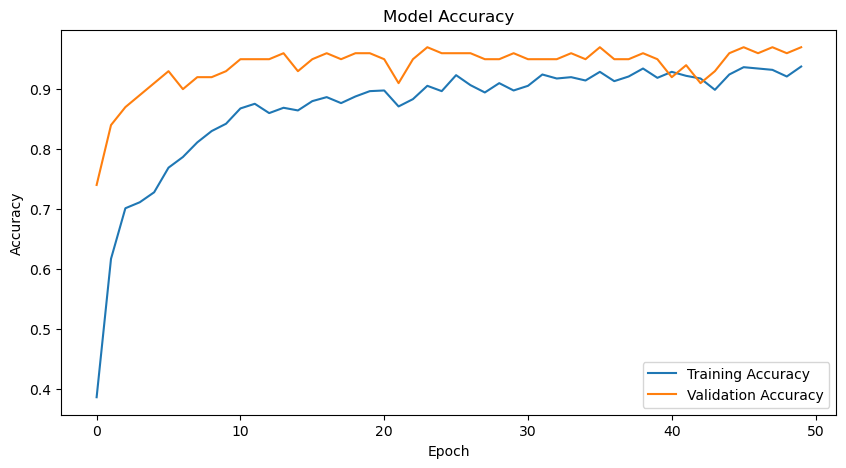

In [34]:
# Plot Accuracy
if 'history' in locals():
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

In [35]:
# Install tensorflowjs if not already installed
# !pip install tensorflowjs

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Classification Report:
              precision    recall  f1-score   support

          AS       1.00      1.00      1.00        20
          MR       1.00      0.90      0.95        20
          MS       0.95      0.95      0.95        20
         MVP       0.95      1.00      0.98        20
           N       0.95      1.00      0.98        20

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100



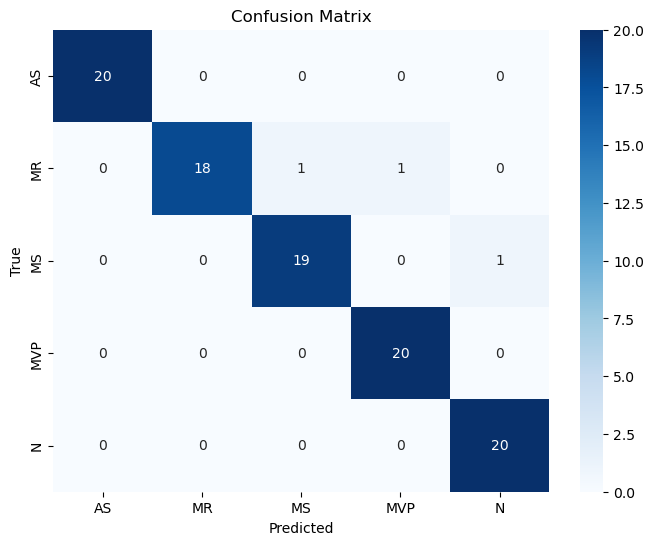

In [36]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Predict classes
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_encoded, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [37]:
# save model h5
model.save('model.h5')

In [38]:
import numpy as np
# Monkey patch np.bool 
np.bool = bool

In [39]:
# Save Model for TensorFlow.js using CLI
import os

if os.path.exists('model.h5'):
    print("Converting model.h5 to TensorFlow.js format...")
    !tensorflowjs_converter --input_format=keras model.h5 model_js
    
    if os.path.exists('model_js/model.json'):
         print("SUCCESS: model.json found in model_js/")
    else:
         print("FAILURE: model.json not found. The conversion likely failed.")
else:
    print("model.h5 not found. Please ensure the model was saved.")

Converting model.h5 to TensorFlow.js format...
FAILURE: model.json not found. The conversion likely failed.


2026-01-15 00:12:44.239223: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-15 00:12:45.757838: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
C:\Users\Rafli\anaconda3\envs\LLM\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
C:\Users\Rafli\anaconda3\envs\LLM\Lib\site-packages\tensorflowjs\read_weights.py:28: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  np.uint8, np.uint16, np.